In [4]:
import fitz
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
from io import BytesIO
from PIL import Image
import os
from tqdm import tqdm
from time import time


In [5]:
def rotate(img, angle, rotPoint=None):
    (h,w) = img.shape[:2]
    if rotPoint is None:
        rotPoint = (w//2, h//2)
    rotMat = cv.getRotationMatrix2D(rotPoint, angle, 1.0)
    dims = (w,h)
    return cv.warpAffine(img, rotMat, dims, borderValue=255)

def content_indexor(arr):
    
    arr_thresh = arr > 1
    arr_extended = np.insert(arr_thresh, [0, arr.shape[0]], 0)
    arr_shift_l = arr_extended[1:]
    arr_shift_r = arr_extended[:-1]
    
    start = np.argwhere((arr_shift_l > arr_shift_r)==True)
    end = np.argwhere((arr_shift_l < arr_shift_r)==True)
    
    cord = [(s[0], e[0]) for s, e in zip(start, end)]
    
    cord_2 = np.concatenate((start, end), axis=1)
    cord_2 = np.delete(cord_2, np.argwhere((cord_2[:, 1]-cord_2[:, 0])<=3), axis=0)
    
    return cord_2

In [6]:
def cv_man(img, name="untitled", rot_portion=5):
    log = []
    debug = []
    
    sh = img.shape
    img = img[30:sh[0]-30, 5:sh[1]-5]
    
    debug.append(img)
#     plt.imshow(img, cmap="gray")
#     plt.show()
    
    img = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    ret, img = cv.threshold(img, 160, 255, cv.THRESH_BINARY)
    
    debug.append(img)
#     plt.imshow(img, cmap="gray")
#     plt.show()
    
    try:
        portion = int(img.shape[0]/rot_portion)
        ub = np.argwhere(img[portion] == 0)[0][0]
        lb = np.argwhere(img[(rot_portion-1)*portion] == 0)[0][0]
        hb = (rot_portion-2)*portion
        deg = np.arctan((ub-lb)/hb) * 180 / np.pi
        img = rotate(img, deg)
        
        debug.append(img)
    except:
        log.append(f"error while rotating {name}")
    
#     plt.imshow(img, cmap="gray")
#     plt.show()
    
    try:
        img = img/255
        img = 1 - img
        portion_0 = int(img.shape[0]/2)
        portion_1 = int(img.shape[1]/2)
        mid_0 = np.argwhere(np.sum(img[portion_0-200:portion_0+200], axis=0) >= 120)
        mid_1 = np.argwhere(np.sum(img[:,portion_1-200:portion_1+200], axis=1) >= 200)
        img = img[mid_1[0,0]:mid_1[-1,0], mid_0[0,0]:mid_0[-1,0]]
        
        debug.append(img)
    except:
        log.append(f"error while bordering {name}")

#     plt.imshow(img, cmap="gray")
#     plt.show()
#     print(img.shape)
    
    try:
        img = cv.resize(img, (2000, 2520), interpolation=cv.INTER_AREA)
        os.makedirs(f"test_img/{name.split('.')[0]}", exist_ok=True)
        png = Image.fromarray((1-img)*255).convert("L")
        png.save(f"test_img/{name.split('.')[0]}/zz{name.split('.')[0]}.png")
    
        debug.append(img)
    except:
        log.append(f"error while resizing {name}")

#     plt.imshow(img, cmap="gray")
#     plt.show()
#     print(img.shape)

    try:
        img = img[254:310, 1750:1905]
        
        sum_ = np.sum(img, axis=1)
        sum_ = sum_ > 0.1
        sum_sh = np.append(sum_[1:], False)
        
        
        
        for i in (np.argwhere(sum_>sum_sh) + 1):
            if i > 10:
                end = i[0]
                break
        
        img = img[:end]
            
        
        debug.append(img)
    except:
        log.append(f"error while cropping {name}")
        
    #     plt.imshow(img, cmap="gray")
    #     plt.show()
    #     print(img.shape)
    
    os.makedirs(f"test_img/{name.split('.')[0]}", exist_ok=True)
    png = Image.fromarray((1-img)*255).convert("L")
    png.save(f"test_img/{name.split('.')[0]}/z{name.split('.')[0]}.png")
    
    try:
        axis_x = np.sum(img, axis=0)
        axis_y = np.sum(img, axis=1)
        cord_x = content_indexor(axis_x)
        cord_y = content_indexor(axis_y)
        

        S_y = cord_y[0][0]
        E_y = cord_y[0][1]
        imgs = []
        for i, (S_x, E_x) in enumerate(cord_x):
            sub_img = img[S_y:E_y, S_x:E_x]
            imgs.append(1-sub_img)
            sub_img = Image.fromarray((1-sub_img)*255).convert("L")
            sub_img.save(f"test_img/{name.split('.')[0]}/{name.split('.')[0]}_{i}.png")
        if len(imgs) != 5:
            log.append(f"number of segments is not right for {name}")
    except:
        log.append(f"error while segmenting {name}")
    return imgs, log, debug

In [7]:
path = 'new data/'
path = 'Resources/Tables/1-ID/'
items = os.listdir(path)

mat = fitz.Matrix(4,4)
#pool = np.random.choice(items, 5, replace=False)
#pool = [i + ".pdf" for i in ["336", '337', '059', '081', '101', '131', '152', '158', '230', '335']] 
#pool = ['138.pdf', '265.pdf']
#pool = ['1_7-PDF_شناسنامه لوله ها.pdf']
pool = items 

log = []

plus = 0
for i in tqdm(pool):
    pdf = fitz.open(path + i)
    page = pdf.load_page(0)
    img = page.get_pixmap(matrix=mat)
    img.save("fff.jpg")
    img = Image.open(BytesIO(img.tobytes()))
    arr = np.array(img)
    arr, l , de = cv_man(arr, name = i)
    log.append(l) if len(l) != 0 else ...

    #plus = plus + de[-2]

 81%|████████████████████████████████████████████████████████████████▌               | 336/416 [13:21<03:10,  2.39s/it]


UnboundLocalError: local variable 'imgs' referenced before assignment

In [31]:
len(arr)

5

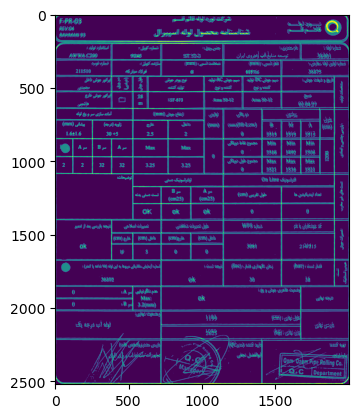

In [45]:
plus.shape
plt.imshow(plus)

In [15]:
log

[]

In [16]:
for i, a in enumerate(arr):
    np.save(f"tf_model/data/numpy/test_{i}.npy", a)